### Printed and handwritten text extraction from images using Tesseract and Google Cloud Vision API

Text extraction from image files is an useful technique for document digitalization. There are several well developed OCR engines for printed text extraction, such as Tesseract and EasyOCR [1]. However, for handwritten text extraction, it's more challenging because of large variations in handwritings from person to person. Tesseract and EasyOCR can't achieve satisfacting results unless the texts are hand printed. In this post, I will describe how to use Tesseract to extract printed texts, and use Google Cloud Vision API to extract handwritten texts.
<br>
<br>
The example text image file is from the IAM handwriting dataset [2]. 
<br>
<br>
The following major tools are used:<br>

**OpenCV**, For finding structures in the images to automatically break the images into printed segments and handwritten segments<br>
**Google Cloud Vision API**, For extract text from handwriting segment<br>
**Tesseract and Pytesseract**, For extract text from printed segment<br>


In [3]:
%reset -sf
from IPython.display import Image
from matplotlib import pyplot as plt
import pandas as pd, numpy as np
pd.options.display.float_format = '{:,.2f}'.format

from google.cloud import vision
import io

import warnings
warnings.simplefilter("ignore")

import os, cv2
os.chdir(r"/Users/pedroleal/Desktop/Ironhack/Final project/Project/Cloudvision/HandwritingRecognition_GoogleCloudVision/images")
         
fileList = [x for x in os.listdir() if 'jpg'  in x.lower()]
fileList[:10]


['full2_box.jpg',
 'full3_box.jpg',
 'full_box.jpg',
 '3_box.jpg',
 'full2.JPG',
 '3equation.JPG',
 '4.JPG',
 '3equation_box.jpg',
 '2.JPG',
 '3.JPG']

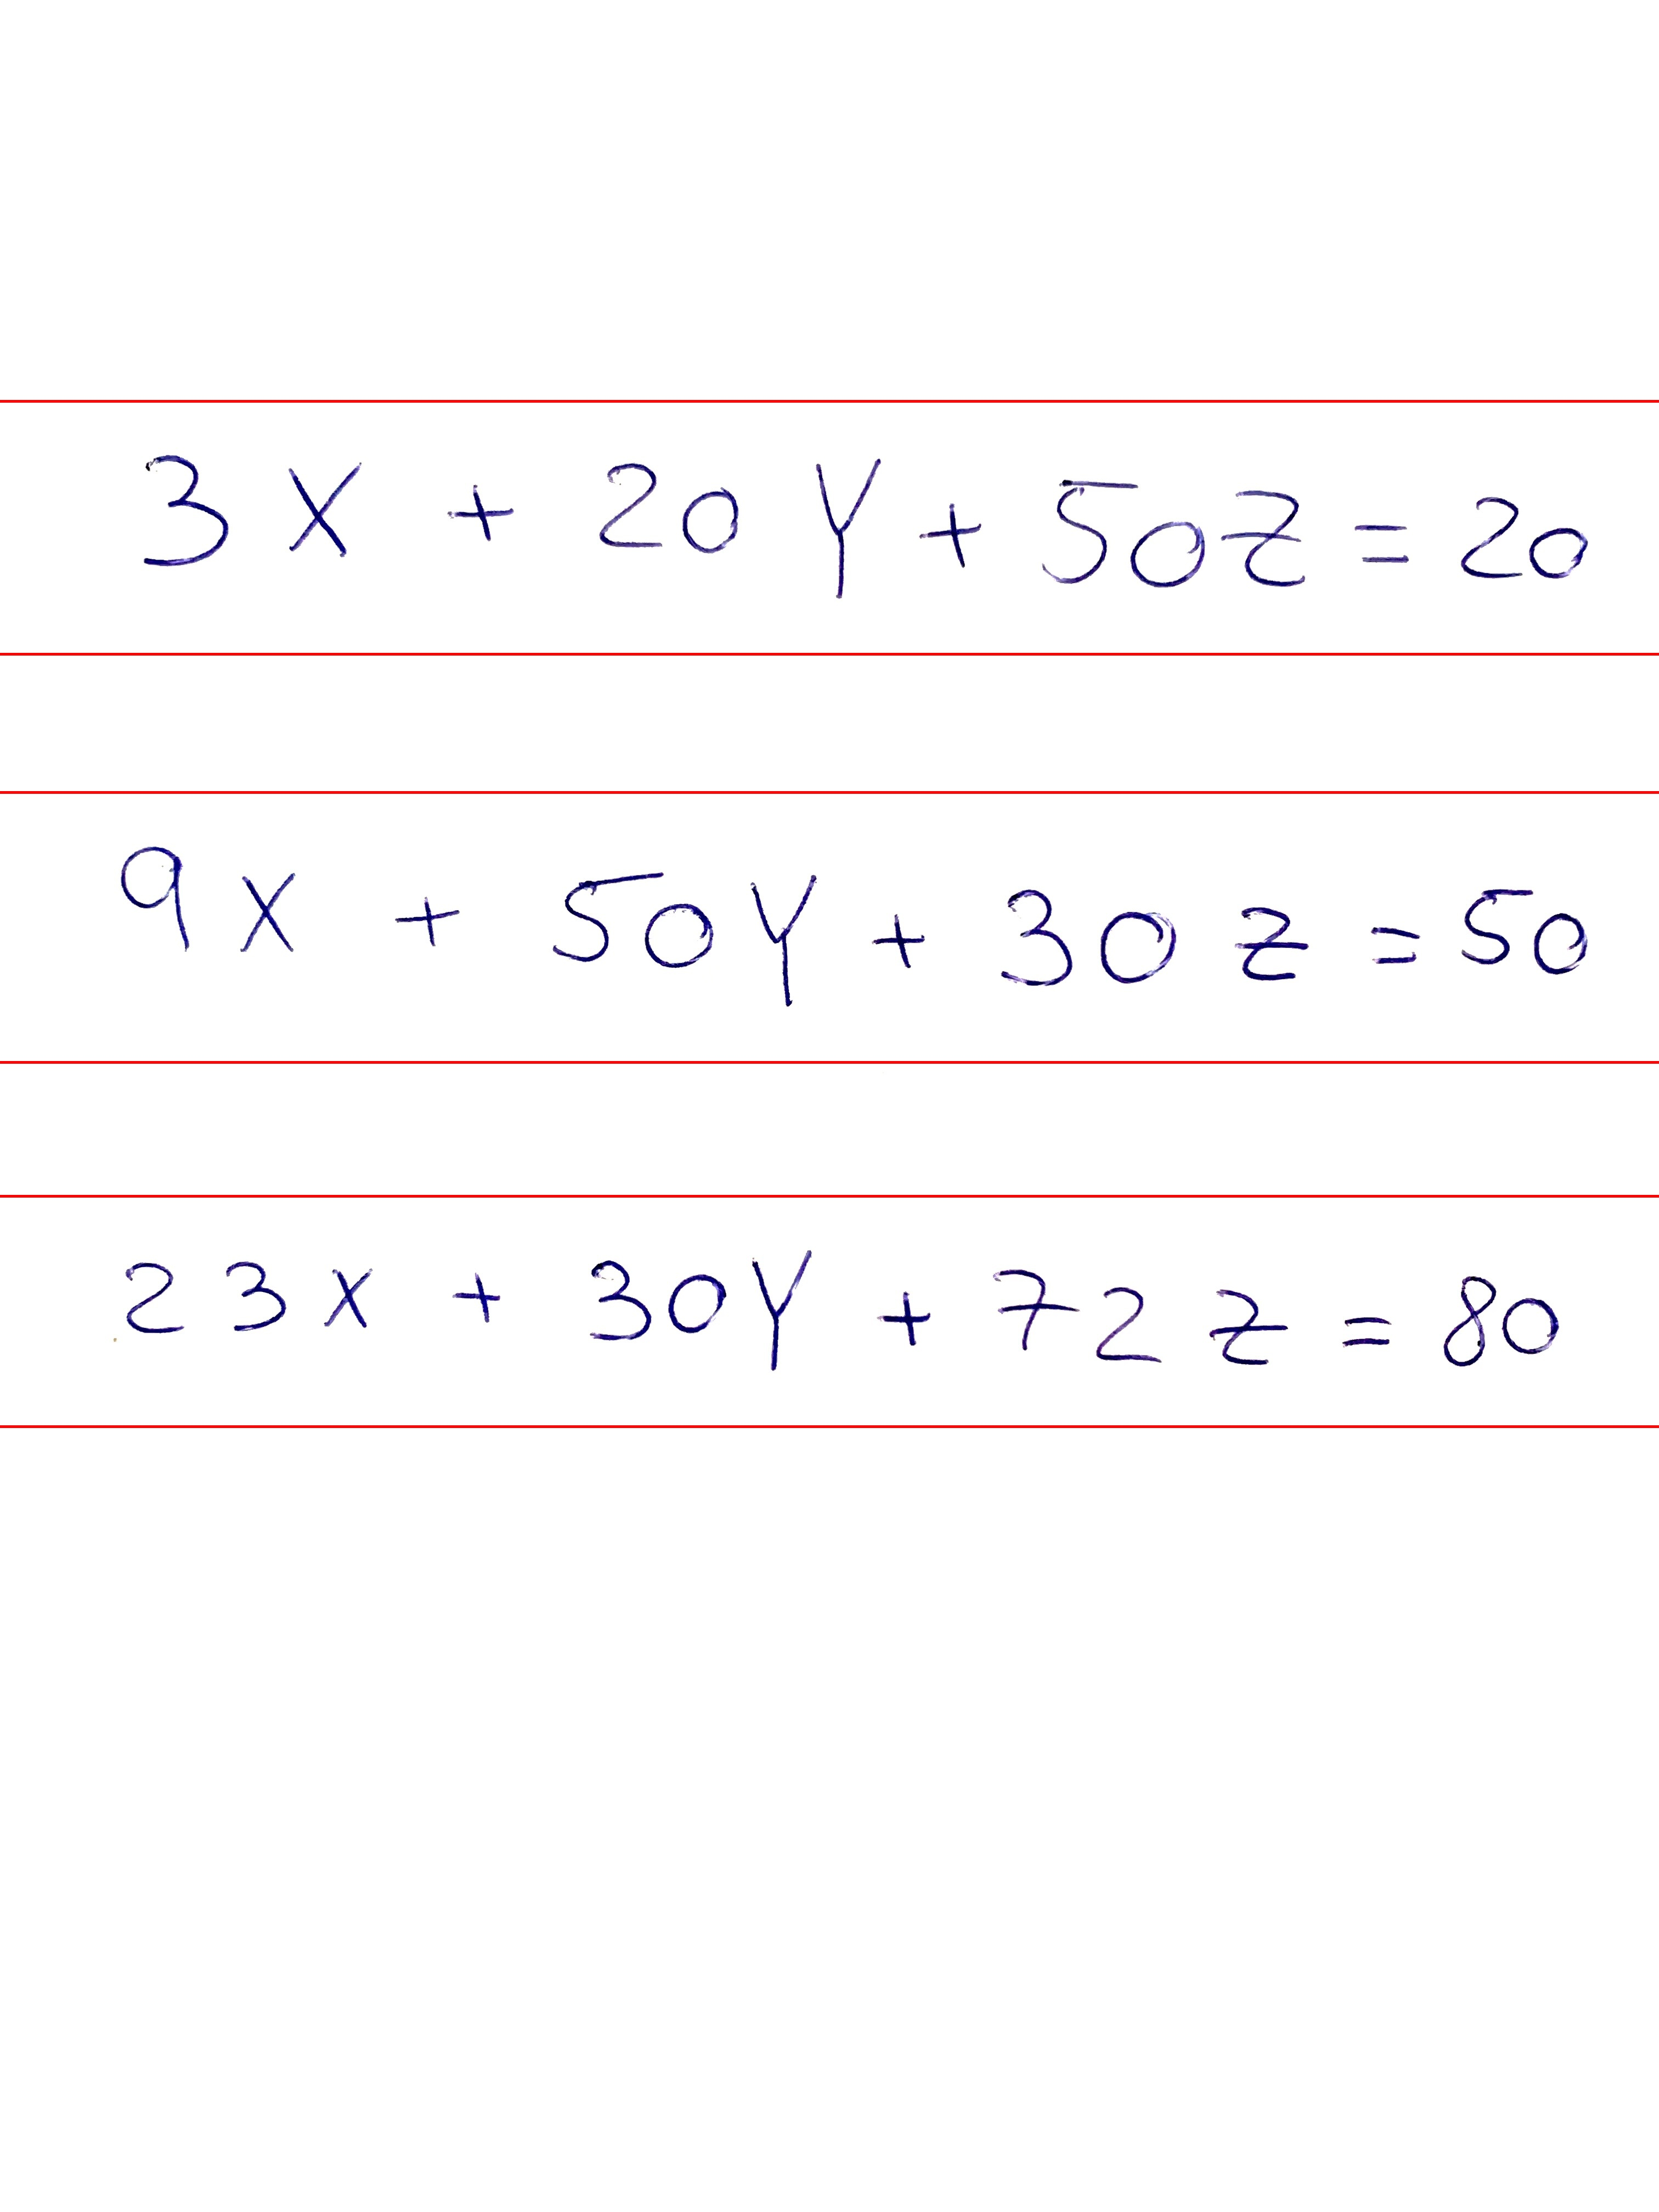

In [4]:
image_use=1
Image(filename = fileList[image_use], width = 300)

## Step 1. Page Segmentation

Use OpenCV to find lines between sections, and use the coordinates of the lines to break the image into segments.

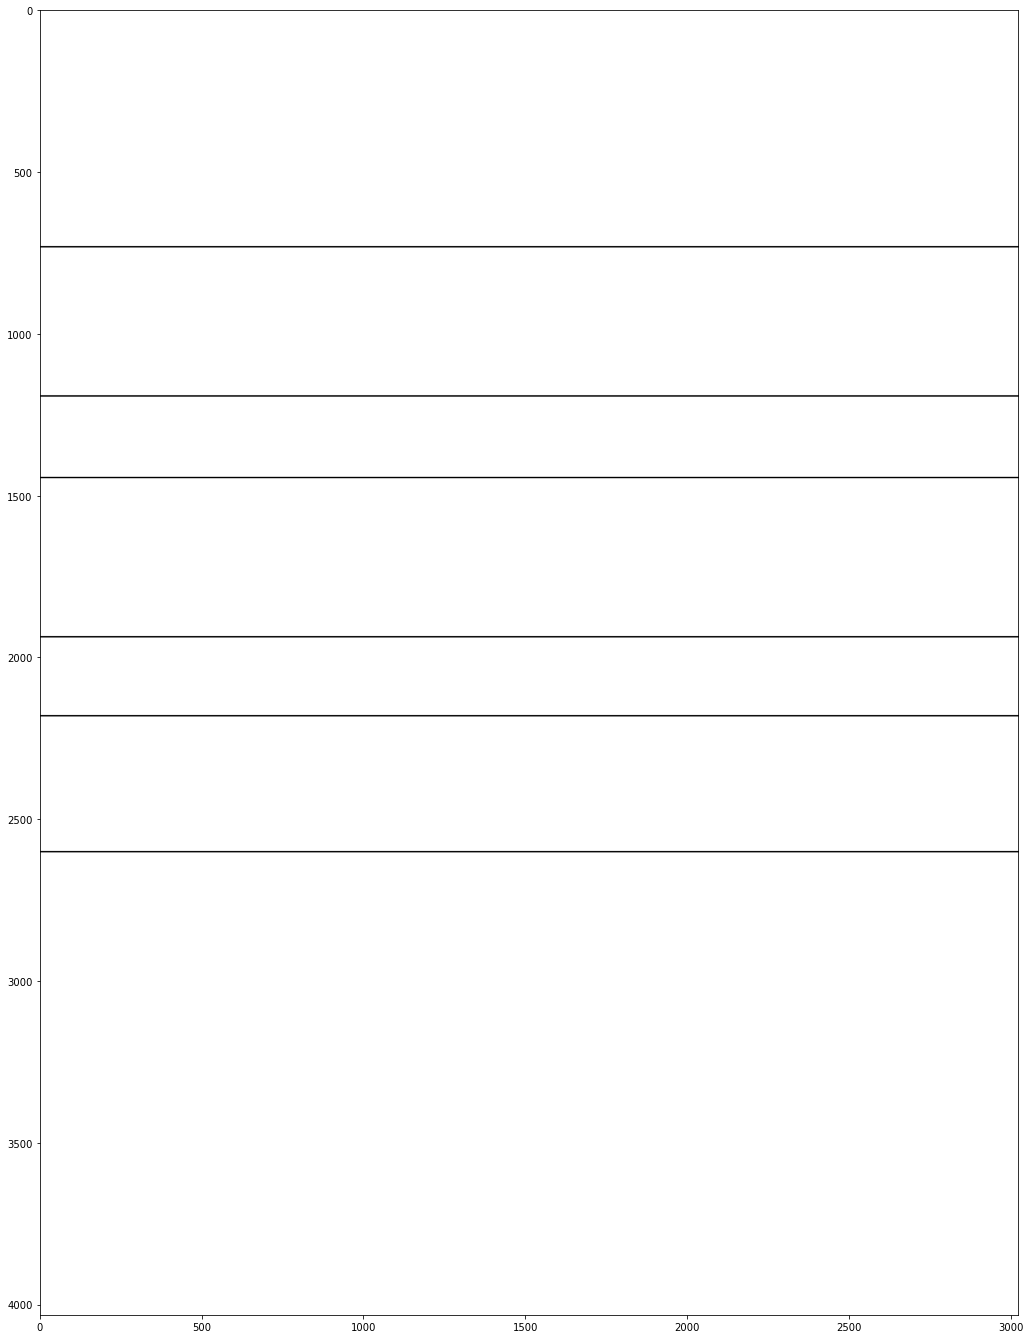

In [5]:
img = fileList[image_use]

def findHorizontalLines(img):
    img = cv2.imread(img) 
    
    #convert image to greyscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # set threshold to remove background noise
    thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    
    # define rectangle structure (line) to look for: width 100, hight 1. This is a 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200,1))
    
    # Find horizontal lines
    lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    return lineLocations

lineLocations = findHorizontalLines(img)
plt.figure(figsize=(24,24))
plt.imshow(lineLocations, cmap='Greys')

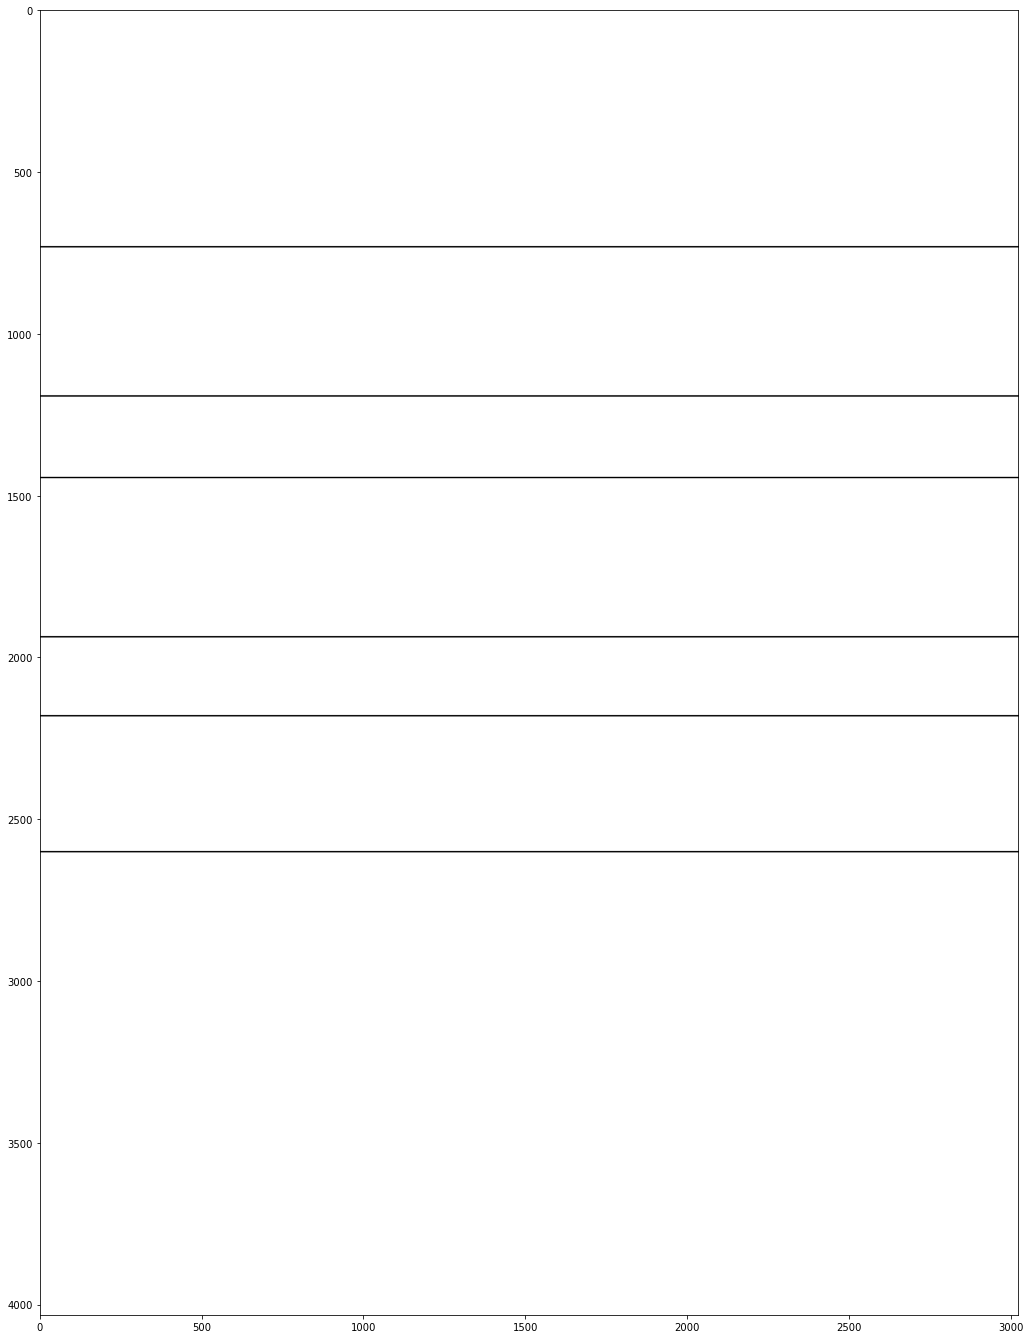

In [6]:
img = fileList[image_use]


img = cv2.imread(img) 

#convert image to greyscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# set threshold to remove background noise
thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


# define rectangle structure (line) to look for: width 100, hight 1. This is a 
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (500,1))

# Find horizontal lines
lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    


#lineLocations = findHorizontalLines(img)
plt.figure(figsize=(24,24))
plt.imshow(lineLocations, cmap='Greys')

In [7]:
df_lineLocations = pd.DataFrame(lineLocations.sum(axis=1)).reset_index()
df_lineLocations.columns = ['rowLoc', 'LineLength']
df_lineLocations[df_lineLocations['LineLength'] > 50]

,rowLoc,LineLength
729,729,771120
730,730,771120
731,731,771120
732,732,771120
733,733,771120
1190,1190,771120
1191,1191,771120
1192,1192,771120
1193,1193,771120
1194,1194,771120


In [8]:
df_lineLocations['line'] = 0
df_lineLocations['line'][df_lineLocations['LineLength'] > 100] = 1

df_lineLocations['cumSum'] = df_lineLocations['line'].cumsum()

In [9]:
df_lineLocations.head()

,rowLoc,LineLength,line,cumSum
0,0,0,0,0
1,1,0,0,0
2,2,0,0,0
3,3,0,0,0
4,4,0,0,0


In [10]:
import pandasql as ps

query = '''
select row_number() over (order by cumSum) as SegmentOrder
, min(rowLoc) as SegmentStart
, max(rowLoc) - min(rowLoc) as Height
from df_lineLocations
where line = 0
--and CumSum !=0
group by cumSum
'''

df_SegmentLocations  = ps.sqldf(query, locals())
df_SegmentLocations

,SegmentOrder,SegmentStart,Height
0,1,0,728
1,2,734,455
2,3,1195,246
3,4,1447,486
4,5,1939,238
5,6,2183,414
6,7,2603,1428


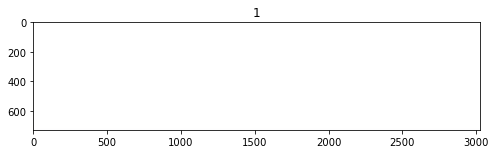

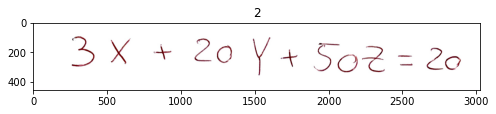

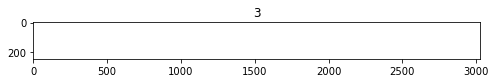

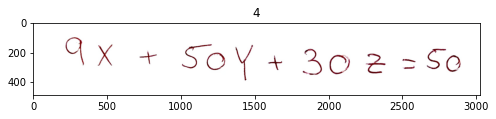

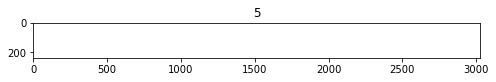

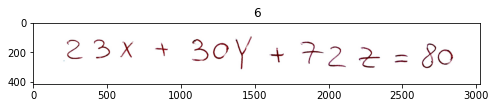

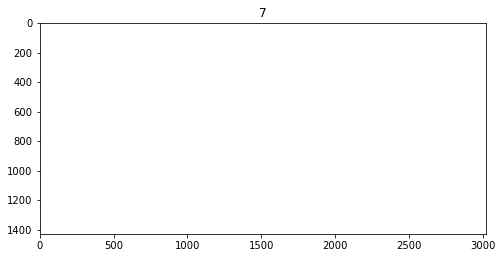

In [11]:
def pageSegmentation1(img, w, df_SegmentLocations):
    img = cv2.imread(img) 
    im2 = img.copy()
    segments = []

    for i in range(len(df_SegmentLocations)):
        y = df_SegmentLocations['SegmentStart'][i]
        h = df_SegmentLocations['Height'][i]

        cropped = im2[y:y + h, 0:w] 
        segments.append(cropped)
        plt.figure(figsize=(8,8))
        plt.imshow(cropped)
        plt.title(str(i+1))        

    return segments

img = fileList[image_use]
w = lineLocations.shape[1]
segments = pageSegmentation1(img, w, df_SegmentLocations)

# Step 3. Extract handwritten text using Google Cloud Vision API

In [12]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/pedroleal/Desktop/Ironhack/Final project/Project/Cloudvision/HandwritingRecognition_GoogleCloudVision/my-key.json"
print('Credendtials from environ: {}'.format(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')))

Credendtials from environ: /Users/pedroleal/Desktop/Ironhack/Final project/Project/Cloudvision/HandwritingRecognition_GoogleCloudVision/my-key.json


In [13]:

def CloudVisionTextExtractor(handwritings):
    # convert image from numpy to bytes for submittion to Google Cloud Vision
    _, encoded_image = cv2.imencode('.png', handwritings)
    content = encoded_image.tobytes()
    #image = vision.types.Image(content=content)
    image = vision.Image(content=content)
    
    # feed handwriting image segment to the Google Cloud Vision API
    client = vision.ImageAnnotatorClient()
    response = client.document_text_detection(image=image)
    
    return response

def getTextFromVisionResponse(response):
    texts = []
    for page in response.full_text_annotation.pages:
        for i, block in enumerate(page.blocks):  
            for paragraph in block.paragraphs:       
                for word in paragraph.words:
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    texts.append(word_text)

    return ' '.join(texts)

In [14]:
#handwritings = segments[0]
handwritings=segments[1]
response = CloudVisionTextExtractor(handwritings)
handwrittenText = getTextFromVisionResponse(response)
print(handwrittenText)

3 X + 20 Y + 50Z = 20


In [15]:
handwritings=cv2.bitwise_not((segments[1]))
response = CloudVisionTextExtractor(handwritings)
handwrittenText = getTextFromVisionResponse(response)
print(handwrittenText)

3 X + 20 Y + 50Z = 20


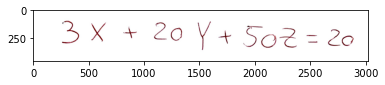

In [16]:
plt.imshow(segments[1]) 

In [33]:
handwritings=cv2.bitwise_not(cv2.bitwise_not(segments[3]))
response = CloudVisionTextExtractor(handwritings)
handwrittenText = getTextFromVisionResponse(response)
print(handwrittenText)

ах x + 50Y + 30 z = 50 근


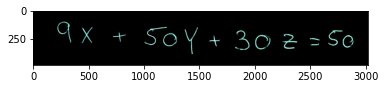

In [83]:
plt.imshow(cv2.bitwise_not(segments[3]))

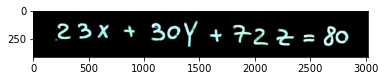

In [93]:
kernel = np.ones((5, 5), np.uint8)


img_dilation = cv2.dilate(cv2.bitwise_not(segments[5]), kernel, iterations=3)


handwritings=cv2.bitwise_not(img_dilation)
response = CloudVisionTextExtractor(handwritings)
handwrittenText = getTextFromVisionResponse(response)

plt.imshow(img_dilation)

['9x ', ' 50Y ', ' 30 z = 50']
['9x X ', ' 50Y ', ' 30 z = So 50']
['9x ', ' 50Y ', ' 30 z = 50']
['9x ', ' 50Y ', ' 30 z = 50']
['9x ', ' 50Y ', ' 30 z = 50 2']
['9x ', ' 50y ', ' 30 2 = 50']
['9x ', ' 50Y ', ' 30 2 = 50']
['9x ', ' 50y ', ' 30 2 = 50']
['9x ', ' 50Y ', ' 30 ± = 50 т']
['9x ', ' 50y ', ' 30 = = 50']


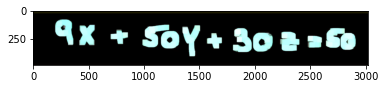

In [88]:
first_element=[]
second_element=[]
third_element=[]

for i in range(1,11):

    kernel = np.ones((5, 5), np.uint8)


    img_dilation = cv2.dilate(cv2.bitwise_not(segments[3]), kernel, iterations=i)


    handwritings=cv2.bitwise_not(img_dilation)
    response = CloudVisionTextExtractor(handwritings)
    handwrittenText = getTextFromVisionResponse(response)
    print(handwrittenText.split("+"))
    first_element.append(handwrittenText.split("+")[0].strip().lower())
    second_element.append(handwrittenText.split("+")[1].strip().lower())
    third_element.append(handwrittenText.split("+")[2].strip().lower())

    
plt.imshow(img_dilation)





In [99]:
from collections import Counter
 
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]
   
List = first_element
print(most_frequent(List))

List = second_element
print(most_frequent(List))

List = third_element
print(most_frequent(List).split("="))

9x
50y
['30 z ', ' 50']


In [103]:
most_frequent(List).split("=")[0].replace(" ","")

'30z'